In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os


In [2]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

DIRECTORY = r"D:\projects\Mask Detection\dataset"
CATEGORIES = ["with_mask","without_mask"]

In [3]:
data = []
labels = []

for category in CATEGORIES:
	path = os.path.join(DIRECTORY,category)
	for img in os.listdir(path):
		img_path = os.path.join(path, img)
		image = load_img(img_path, target_size=(224,224))
		image = img_to_array(image)
		image = preprocess_input(image)

		data.append(image)
		labels.append(category)

C:\Users\YUG\anaconda3\envs\tf\lib\site-packages\PIL\Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [4]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data,dtype="float32")
labels = np.array(labels)

(trainX,testX,trainY,testY) = train_test_split(data,labels,test_size=0.20,
	stratify=labels, random_state=42)

In [5]:
aug = ImageDataGenerator(rotation_range=20,zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.15,horizontal_flip=True,fill_mode="nearest")

In [6]:
baseModel = MobileNetV2(weights="imagenet",include_top=False,input_tensor=Input(shape=(224,224,3)))

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7,7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128,activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2,activation="softmax")(headModel)


In [7]:
model = Model(inputs=baseModel.input ,outputs=headModel)

for layer in baseModel.layers:
	layer.trainable = False

opt = Adam(lr = INIT_LR,decay=INIT_LR/EPOCHS)
model.compile(loss="binary_crossentropy",optimizer=opt,
	metrics=["accuracy"])

In [8]:
H = model.fit(
	aug.flow(trainX,trainY,batch_size=BS),
	steps_per_epoch=len(trainX)//BS,
	validation_data=(testX,testY),
	validation_steps=len(testX)//BS,
	epochs=EPOCHS)
predIdxs = model.predict(testX,batch_size=BS)

Epoch 1/20
95/95 [==============================] - 95s 1s/step - loss: 0.3954 - accuracy: 0.8276 - val_loss: 0.1060 - val_accuracy: 0.9765
Epoch 2/20
95/95 [==============================] - 88s 930ms/step - loss: 0.1177 - accuracy: 0.9595 - val_loss: 0.0597 - val_accuracy: 0.9870
Epoch 3/20
95/95 [==============================] - 86s 907ms/step - loss: 0.0868 - accuracy: 0.9700 - val_loss: 0.0477 - val_accuracy: 0.9896
Epoch 4/20
95/95 [==============================] - 87s 919ms/step - loss: 0.0689 - accuracy: 0.9766 - val_loss: 0.0397 - val_accuracy: 0.9909
Epoch 5/20
95/95 [==============================] - 87s 918ms/step - loss: 0.0625 - accuracy: 0.9802 - val_loss: 0.0370 - val_accuracy: 0.9922
Epoch 6/20
95/95 [==============================] - 88s 926ms/step - loss: 0.0446 - accuracy: 0.9878 - val_loss: 0.0348 - val_accuracy: 0.9922
Epoch 7/20
95/95 [==============================] - 85s 896ms/step - loss: 0.0424 - accuracy: 0.9875 - val_loss: 0.0311 - val_accuracy: 0.9909
Ep

In [9]:
predIdxs = np.argmax(predIdxs,axis = 1)

print(classification_report(testY.argmax(axis=1),predIdxs,
	target_names=lb.classes_))


model.save("mask_detector.model",save_format='h5')

              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       383
without_mask       0.99      0.99      0.99       384

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767



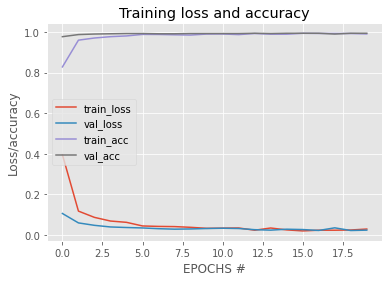

In [14]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0,N),H.history["loss"],label='train_loss')
plt.plot(np.arange(0,N),H.history["val_loss"],label="val_loss")
plt.plot(np.arange(0,N),H.history["accuracy"],label="train_acc")
plt.plot(np.arange(0,N),H.history["val_accuracy"],label="val_acc")
plt.title("Training loss and accuracy")
plt.xlabel("EPOCHS #")
plt.ylabel("Loss/accuracy")
plt.legend(loc="center left")
	

In [1]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from imutils.video import VideoStream
import imutils
import numpy as np
import time
import cv2
import os


In [2]:
def detect_and_predict_mask(frame, faceNet, maskNet):
	# grab the dimensions of the frame and then construct a blob
	# from it
	(h, w) = frame.shape[:2]
	blob = cv2.dnn.blobFromImage(frame, 1.0, (224, 224),
		(104.0, 177.0, 123.0))

	# pass the blob through the network and obtain the face detections
	faceNet.setInput(blob)
	detections = faceNet.forward()
	print(detections.shape)

	# initialize our list of faces, their corresponding locations,
	# and the list of predictions from our face mask network
	faces = []
	locs = []
	preds = []

	# loop over the detections
	for i in range(0, detections.shape[2]):
		# extract the confidence (i.e., probability) associated with
		# the detection
		confidence = detections[0, 0, i, 2]

		# filter out weak detections by ensuring the confidence is
		# greater than the minimum confidence
		if confidence > 0.5:
			# compute the (x, y)-coordinates of the bounding box for
			# the object
			box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
			(startX, startY, endX, endY) = box.astype("int")

			# ensure the bounding boxes fall within the dimensions of
			# the frame
			(startX, startY) = (max(0, startX), max(0, startY))
			(endX, endY) = (min(w - 1, endX), min(h - 1, endY))

			# extract the face ROI, convert it from BGR to RGB channel
			# ordering, resize it to 224x224, and preprocess it
			face = frame[startY:endY, startX:endX]
			face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
			face = cv2.resize(face, (224, 224))
			face = img_to_array(face)
			face = preprocess_input(face)

			# add the face and bounding boxes to their respective
			# lists
			faces.append(face)
			locs.append((startX, startY, endX, endY))

	# only make a predictions if at least one face was detected
	if len(faces) > 0:
		# for faster inference we'll make batch predictions on *all*
		# faces at the same time rather than one-by-one predictions
		# in the above `for` loop
		faces = np.array(faces, dtype="float32")
		preds = maskNet.predict(faces, batch_size=32)

	# return a 2-tuple of the face locations and their corresponding
	# locations
	return (locs, preds)

In [14]:
prototxtPath = r"C:\Mask Detection\face_detector\deploy.prototxt"
weightsPath = r"C:\Mask Detection\face_detector\res10_300x300_ssd_iter_140000.caffemodel"
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)

maskNet = load_model("mask_detector.model")

vs = VideoStream(src=0).start()

while True:
    
    frame = vs.read()
    frame = imutils.resize(frame,width=400)
    
    (locs,preds) =  detect_and_predict_mask(frame,faceNet,maskNet)
    
    for box,pred in zip(locs,preds):
        startX,startY,endX,endY = box
        mask,withoutMask = pred
        
        label = "Mask" if mask > withoutMask else "No Mask"
        color = (0,255,0) if label == "Mask" else (0,0,255)
        
        label = "{}: {:.2f}%".format(label,max(mask,withoutMask)*100)
        
        cv2.putText(frame,label,(startX,startY-10),cv2.FONT_HERSHEY_SIMPLEX,0.45,color,2)
        cv2.rectangle(frame,(startX,startY),(endX,endY),color,2)
    
    cv2.imshow("Frame",frame)
    key = cv2.waitKey(1) & 0xFF
    
    if key == ord("q"):
        break
cv2.destroyAllWindows()
vs.stop()

(1, 1, 96, 7)
(1, 1, 96, 7)
(1, 1, 93, 7)
(1, 1, 92, 7)
(1, 1, 94, 7)
(1, 1, 92, 7)
(1, 1, 84, 7)
(1, 1, 84, 7)
(1, 1, 92, 7)
(1, 1, 92, 7)
(1, 1, 92, 7)
(1, 1, 97, 7)
(1, 1, 91, 7)
(1, 1, 91, 7)
(1, 1, 91, 7)
(1, 1, 91, 7)
(1, 1, 85, 7)
(1, 1, 82, 7)
(1, 1, 82, 7)
(1, 1, 89, 7)
(1, 1, 92, 7)
(1, 1, 90, 7)
(1, 1, 99, 7)
(1, 1, 99, 7)
(1, 1, 94, 7)
(1, 1, 94, 7)
(1, 1, 92, 7)
(1, 1, 97, 7)
(1, 1, 96, 7)
(1, 1, 95, 7)
(1, 1, 100, 7)
(1, 1, 98, 7)
(1, 1, 93, 7)
(1, 1, 92, 7)
(1, 1, 95, 7)
(1, 1, 96, 7)
(1, 1, 98, 7)
(1, 1, 101, 7)
(1, 1, 101, 7)
(1, 1, 98, 7)
(1, 1, 98, 7)
(1, 1, 94, 7)
(1, 1, 93, 7)
(1, 1, 93, 7)
(1, 1, 96, 7)
(1, 1, 96, 7)
(1, 1, 95, 7)
(1, 1, 95, 7)
(1, 1, 94, 7)
(1, 1, 96, 7)
(1, 1, 96, 7)
(1, 1, 99, 7)
(1, 1, 99, 7)
(1, 1, 95, 7)
(1, 1, 95, 7)
(1, 1, 93, 7)
(1, 1, 90, 7)
(1, 1, 90, 7)
(1, 1, 88, 7)
(1, 1, 92, 7)
(1, 1, 96, 7)
(1, 1, 101, 7)
(1, 1, 94, 7)
(1, 1, 98, 7)
(1, 1, 94, 7)
(1, 1, 94, 7)
(1, 1, 97, 7)
(1, 1, 97, 7)
(1, 1, 90, 7)
(1, 1, 96, 7)
(1, 1, 96, 7)
(1

(1, 1, 98, 7)
(1, 1, 96, 7)
(1, 1, 96, 7)
(1, 1, 95, 7)
(1, 1, 95, 7)
(1, 1, 98, 7)
(1, 1, 100, 7)
(1, 1, 100, 7)
(1, 1, 100, 7)
(1, 1, 97, 7)
(1, 1, 88, 7)
(1, 1, 88, 7)
(1, 1, 93, 7)
(1, 1, 93, 7)
(1, 1, 107, 7)
(1, 1, 100, 7)
(1, 1, 100, 7)
(1, 1, 105, 7)
(1, 1, 105, 7)
(1, 1, 109, 7)
(1, 1, 109, 7)
(1, 1, 106, 7)
(1, 1, 106, 7)
(1, 1, 110, 7)
(1, 1, 110, 7)
(1, 1, 102, 7)
(1, 1, 102, 7)
(1, 1, 91, 7)
(1, 1, 91, 7)
(1, 1, 94, 7)
(1, 1, 94, 7)
(1, 1, 96, 7)
(1, 1, 96, 7)
(1, 1, 98, 7)
(1, 1, 98, 7)
(1, 1, 98, 7)
(1, 1, 89, 7)
(1, 1, 89, 7)
(1, 1, 94, 7)
(1, 1, 94, 7)
(1, 1, 96, 7)
(1, 1, 96, 7)
(1, 1, 102, 7)
(1, 1, 102, 7)
(1, 1, 90, 7)
(1, 1, 90, 7)
(1, 1, 90, 7)
(1, 1, 91, 7)
(1, 1, 91, 7)
(1, 1, 95, 7)
(1, 1, 95, 7)
(1, 1, 91, 7)
(1, 1, 91, 7)
(1, 1, 98, 7)
(1, 1, 102, 7)
(1, 1, 102, 7)
(1, 1, 97, 7)
(1, 1, 97, 7)
(1, 1, 95, 7)
(1, 1, 96, 7)
(1, 1, 96, 7)
(1, 1, 96, 7)
(1, 1, 99, 7)
(1, 1, 90, 7)
(1, 1, 97, 7)
(1, 1, 97, 7)
(1, 1, 97, 7)
(1, 1, 95, 7)
(1, 1, 95, 7)
(1, 1, 95, 7)


(1, 1, 99, 7)
(1, 1, 97, 7)
(1, 1, 97, 7)
(1, 1, 98, 7)
(1, 1, 99, 7)
(1, 1, 96, 7)
(1, 1, 97, 7)
(1, 1, 97, 7)
(1, 1, 107, 7)
(1, 1, 100, 7)
(1, 1, 92, 7)
(1, 1, 94, 7)
(1, 1, 96, 7)
(1, 1, 93, 7)
(1, 1, 89, 7)
(1, 1, 92, 7)
(1, 1, 97, 7)
(1, 1, 101, 7)
(1, 1, 94, 7)
(1, 1, 94, 7)
(1, 1, 97, 7)
(1, 1, 98, 7)
(1, 1, 99, 7)
(1, 1, 95, 7)
(1, 1, 92, 7)
(1, 1, 96, 7)
(1, 1, 98, 7)
(1, 1, 98, 7)
(1, 1, 100, 7)
(1, 1, 96, 7)
(1, 1, 98, 7)
(1, 1, 96, 7)
(1, 1, 96, 7)
(1, 1, 90, 7)
(1, 1, 92, 7)
(1, 1, 92, 7)
(1, 1, 94, 7)
(1, 1, 94, 7)
(1, 1, 94, 7)
(1, 1, 90, 7)
(1, 1, 90, 7)
(1, 1, 90, 7)
(1, 1, 91, 7)
(1, 1, 93, 7)
(1, 1, 91, 7)
(1, 1, 83, 7)
(1, 1, 83, 7)
(1, 1, 91, 7)
(1, 1, 91, 7)
(1, 1, 88, 7)
(1, 1, 88, 7)
(1, 1, 92, 7)
(1, 1, 93, 7)
(1, 1, 93, 7)
(1, 1, 92, 7)
(1, 1, 92, 7)
(1, 1, 96, 7)
(1, 1, 96, 7)
(1, 1, 87, 7)
(1, 1, 87, 7)
(1, 1, 94, 7)
(1, 1, 94, 7)
(1, 1, 92, 7)
(1, 1, 92, 7)
(1, 1, 91, 7)
(1, 1, 91, 7)
(1, 1, 92, 7)
(1, 1, 92, 7)
(1, 1, 97, 7)
(1, 1, 97, 7)
(1, 1, 98, 7)
(1

(1, 1, 102, 7)
(1, 1, 102, 7)
(1, 1, 107, 7)
(1, 1, 109, 7)
(1, 1, 109, 7)
(1, 1, 109, 7)
(1, 1, 112, 7)
(1, 1, 115, 7)
(1, 1, 115, 7)
(1, 1, 118, 7)
(1, 1, 118, 7)
(1, 1, 113, 7)
(1, 1, 113, 7)
(1, 1, 105, 7)
(1, 1, 105, 7)
(1, 1, 105, 7)
(1, 1, 88, 7)
(1, 1, 88, 7)
(1, 1, 90, 7)
(1, 1, 90, 7)
(1, 1, 90, 7)
(1, 1, 96, 7)
(1, 1, 96, 7)
(1, 1, 101, 7)
(1, 1, 101, 7)
(1, 1, 106, 7)
(1, 1, 93, 7)
(1, 1, 93, 7)
(1, 1, 98, 7)
(1, 1, 98, 7)
(1, 1, 99, 7)
(1, 1, 99, 7)
(1, 1, 105, 7)
(1, 1, 105, 7)
(1, 1, 96, 7)
(1, 1, 96, 7)
(1, 1, 96, 7)
(1, 1, 98, 7)
(1, 1, 98, 7)
(1, 1, 96, 7)
(1, 1, 96, 7)
(1, 1, 95, 7)
(1, 1, 95, 7)
(1, 1, 103, 7)
(1, 1, 103, 7)
(1, 1, 102, 7)
(1, 1, 109, 7)
(1, 1, 109, 7)
(1, 1, 101, 7)
(1, 1, 101, 7)
(1, 1, 103, 7)
(1, 1, 104, 7)
(1, 1, 104, 7)
(1, 1, 111, 7)
(1, 1, 111, 7)
(1, 1, 109, 7)
(1, 1, 109, 7)
(1, 1, 105, 7)
(1, 1, 105, 7)
(1, 1, 110, 7)
(1, 1, 105, 7)
(1, 1, 105, 7)
(1, 1, 110, 7)
(1, 1, 110, 7)
(1, 1, 113, 7)
(1, 1, 109, 7)
(1, 1, 109, 7)
(1, 1, 108, 7)
(1

(1, 1, 106, 7)
(1, 1, 106, 7)
(1, 1, 103, 7)
(1, 1, 103, 7)
(1, 1, 106, 7)
(1, 1, 106, 7)
(1, 1, 114, 7)
(1, 1, 111, 7)
(1, 1, 111, 7)
(1, 1, 103, 7)
(1, 1, 103, 7)
(1, 1, 101, 7)
(1, 1, 101, 7)
(1, 1, 101, 7)
(1, 1, 102, 7)
(1, 1, 97, 7)
(1, 1, 97, 7)
(1, 1, 97, 7)
(1, 1, 97, 7)
(1, 1, 93, 7)
(1, 1, 93, 7)
(1, 1, 92, 7)
(1, 1, 90, 7)
(1, 1, 98, 7)
(1, 1, 94, 7)
(1, 1, 88, 7)
(1, 1, 88, 7)
(1, 1, 95, 7)
(1, 1, 96, 7)
(1, 1, 90, 7)
(1, 1, 93, 7)
(1, 1, 90, 7)
(1, 1, 91, 7)
(1, 1, 87, 7)
(1, 1, 88, 7)
(1, 1, 88, 7)
(1, 1, 96, 7)
(1, 1, 97, 7)
(1, 1, 104, 7)
(1, 1, 100, 7)
(1, 1, 98, 7)
(1, 1, 100, 7)
(1, 1, 98, 7)
(1, 1, 95, 7)
(1, 1, 98, 7)
(1, 1, 92, 7)
(1, 1, 91, 7)
(1, 1, 96, 7)
(1, 1, 101, 7)
(1, 1, 93, 7)
(1, 1, 95, 7)
(1, 1, 95, 7)
(1, 1, 87, 7)
(1, 1, 87, 7)
(1, 1, 91, 7)
(1, 1, 94, 7)
(1, 1, 97, 7)
(1, 1, 92, 7)
(1, 1, 93, 7)
(1, 1, 93, 7)
(1, 1, 91, 7)
(1, 1, 91, 7)
(1, 1, 96, 7)
(1, 1, 96, 7)
(1, 1, 99, 7)
(1, 1, 100, 7)
(1, 1, 103, 7)
(1, 1, 103, 7)
(1, 1, 105, 7)
(1, 1, 104,

(1, 1, 102, 7)
(1, 1, 112, 7)
(1, 1, 95, 7)
(1, 1, 107, 7)
(1, 1, 103, 7)
(1, 1, 97, 7)
(1, 1, 97, 7)
(1, 1, 96, 7)
(1, 1, 105, 7)
(1, 1, 107, 7)
(1, 1, 104, 7)
(1, 1, 108, 7)
(1, 1, 110, 7)
(1, 1, 106, 7)
(1, 1, 105, 7)
(1, 1, 109, 7)
(1, 1, 103, 7)
(1, 1, 105, 7)
(1, 1, 107, 7)
(1, 1, 110, 7)
(1, 1, 110, 7)
(1, 1, 107, 7)
(1, 1, 105, 7)
(1, 1, 108, 7)
(1, 1, 112, 7)
(1, 1, 103, 7)
(1, 1, 109, 7)
(1, 1, 105, 7)
(1, 1, 110, 7)
(1, 1, 112, 7)
(1, 1, 106, 7)
(1, 1, 103, 7)
(1, 1, 107, 7)
(1, 1, 110, 7)
(1, 1, 104, 7)
(1, 1, 108, 7)
(1, 1, 108, 7)
(1, 1, 112, 7)
(1, 1, 111, 7)
(1, 1, 108, 7)
(1, 1, 108, 7)
(1, 1, 103, 7)
(1, 1, 108, 7)
(1, 1, 110, 7)
(1, 1, 109, 7)
(1, 1, 112, 7)
(1, 1, 94, 7)
(1, 1, 94, 7)
(1, 1, 95, 7)
(1, 1, 99, 7)
(1, 1, 97, 7)
(1, 1, 100, 7)
(1, 1, 99, 7)
(1, 1, 100, 7)
(1, 1, 106, 7)
(1, 1, 99, 7)
(1, 1, 95, 7)
(1, 1, 97, 7)
(1, 1, 98, 7)
(1, 1, 101, 7)
(1, 1, 97, 7)
(1, 1, 102, 7)
(1, 1, 97, 7)
(1, 1, 97, 7)
(1, 1, 97, 7)
(1, 1, 99, 7)
(1, 1, 99, 7)
(1, 1, 99, 7)
(

(1, 1, 94, 7)
(1, 1, 90, 7)
(1, 1, 93, 7)
(1, 1, 89, 7)
(1, 1, 89, 7)
(1, 1, 88, 7)
(1, 1, 93, 7)
(1, 1, 92, 7)
(1, 1, 92, 7)
(1, 1, 92, 7)
(1, 1, 90, 7)
(1, 1, 87, 7)
(1, 1, 87, 7)
(1, 1, 90, 7)
(1, 1, 95, 7)
(1, 1, 94, 7)
(1, 1, 92, 7)
(1, 1, 94, 7)
(1, 1, 90, 7)
(1, 1, 92, 7)
(1, 1, 87, 7)
(1, 1, 90, 7)
(1, 1, 89, 7)
(1, 1, 90, 7)
(1, 1, 92, 7)
(1, 1, 92, 7)
(1, 1, 89, 7)
(1, 1, 88, 7)
(1, 1, 89, 7)
(1, 1, 89, 7)
(1, 1, 86, 7)
(1, 1, 87, 7)
(1, 1, 87, 7)
(1, 1, 88, 7)
(1, 1, 88, 7)
(1, 1, 92, 7)
(1, 1, 92, 7)
(1, 1, 88, 7)
(1, 1, 88, 7)
(1, 1, 87, 7)
(1, 1, 87, 7)
(1, 1, 91, 7)
(1, 1, 93, 7)
(1, 1, 93, 7)
(1, 1, 85, 7)
(1, 1, 85, 7)
(1, 1, 89, 7)
(1, 1, 89, 7)
(1, 1, 90, 7)
(1, 1, 90, 7)
(1, 1, 89, 7)
(1, 1, 89, 7)
(1, 1, 88, 7)
(1, 1, 88, 7)
(1, 1, 92, 7)
(1, 1, 93, 7)
(1, 1, 93, 7)
(1, 1, 103, 7)
(1, 1, 98, 7)
(1, 1, 102, 7)
(1, 1, 101, 7)
(1, 1, 97, 7)
(1, 1, 94, 7)
(1, 1, 94, 7)
(1, 1, 95, 7)
(1, 1, 95, 7)
(1, 1, 92, 7)
(1, 1, 92, 7)
(1, 1, 90, 7)
(1, 1, 90, 7)
(1, 1, 98, 7)
(1,

(1, 1, 94, 7)
(1, 1, 94, 7)
(1, 1, 96, 7)
(1, 1, 96, 7)
(1, 1, 104, 7)
(1, 1, 104, 7)
(1, 1, 106, 7)
(1, 1, 106, 7)
(1, 1, 104, 7)
(1, 1, 104, 7)
(1, 1, 97, 7)
(1, 1, 92, 7)
(1, 1, 92, 7)
(1, 1, 105, 7)
(1, 1, 94, 7)
(1, 1, 94, 7)
(1, 1, 100, 7)
(1, 1, 100, 7)
(1, 1, 99, 7)
(1, 1, 99, 7)
(1, 1, 98, 7)
(1, 1, 98, 7)
(1, 1, 99, 7)
(1, 1, 99, 7)
(1, 1, 99, 7)
(1, 1, 98, 7)
(1, 1, 98, 7)
(1, 1, 94, 7)
(1, 1, 94, 7)
(1, 1, 97, 7)
(1, 1, 88, 7)
(1, 1, 88, 7)
(1, 1, 88, 7)
(1, 1, 100, 7)
(1, 1, 100, 7)
(1, 1, 103, 7)
(1, 1, 103, 7)
(1, 1, 96, 7)
(1, 1, 96, 7)
(1, 1, 102, 7)
(1, 1, 104, 7)
(1, 1, 104, 7)
(1, 1, 104, 7)
(1, 1, 94, 7)
(1, 1, 94, 7)
(1, 1, 96, 7)
(1, 1, 94, 7)
(1, 1, 94, 7)
(1, 1, 94, 7)
(1, 1, 94, 7)
(1, 1, 96, 7)
(1, 1, 96, 7)
(1, 1, 96, 7)
(1, 1, 96, 7)
(1, 1, 89, 7)
(1, 1, 89, 7)
(1, 1, 86, 7)
(1, 1, 88, 7)
(1, 1, 97, 7)
(1, 1, 108, 7)
(1, 1, 108, 7)
(1, 1, 110, 7)
(1, 1, 110, 7)
(1, 1, 101, 7)
(1, 1, 101, 7)
(1, 1, 106, 7)
(1, 1, 106, 7)
(1, 1, 103, 7)
(1, 1, 103, 7)
(1, 1, 

(1, 1, 96, 7)
(1, 1, 101, 7)
(1, 1, 96, 7)
(1, 1, 96, 7)
(1, 1, 101, 7)
(1, 1, 101, 7)
(1, 1, 95, 7)
(1, 1, 96, 7)
(1, 1, 99, 7)
(1, 1, 94, 7)
(1, 1, 89, 7)
(1, 1, 98, 7)
(1, 1, 94, 7)
(1, 1, 94, 7)
(1, 1, 94, 7)
(1, 1, 96, 7)
(1, 1, 95, 7)
(1, 1, 93, 7)
(1, 1, 91, 7)
(1, 1, 91, 7)
(1, 1, 93, 7)
(1, 1, 91, 7)
(1, 1, 95, 7)
(1, 1, 96, 7)
(1, 1, 90, 7)
(1, 1, 95, 7)
(1, 1, 91, 7)
(1, 1, 92, 7)
(1, 1, 94, 7)
(1, 1, 92, 7)
(1, 1, 92, 7)
(1, 1, 89, 7)
(1, 1, 98, 7)
(1, 1, 99, 7)
(1, 1, 91, 7)
(1, 1, 97, 7)
(1, 1, 93, 7)
(1, 1, 95, 7)
(1, 1, 92, 7)
(1, 1, 95, 7)
(1, 1, 92, 7)
(1, 1, 100, 7)
(1, 1, 95, 7)
(1, 1, 97, 7)
(1, 1, 98, 7)
(1, 1, 96, 7)
(1, 1, 96, 7)
(1, 1, 93, 7)
(1, 1, 95, 7)
(1, 1, 97, 7)
(1, 1, 92, 7)
(1, 1, 94, 7)
(1, 1, 93, 7)
(1, 1, 94, 7)
(1, 1, 98, 7)
(1, 1, 95, 7)
(1, 1, 99, 7)
(1, 1, 96, 7)
(1, 1, 96, 7)
(1, 1, 97, 7)
(1, 1, 98, 7)
(1, 1, 91, 7)
(1, 1, 93, 7)
(1, 1, 90, 7)
(1, 1, 91, 7)
(1, 1, 88, 7)
(1, 1, 94, 7)
(1, 1, 90, 7)
(1, 1, 96, 7)
(1, 1, 98, 7)
(1, 1, 98, 7)
(1